In [1]:
import json, os, re
from metadata_metrics import readability_score, completeness_score_img, completeness_score_jsonxml, completeness_score_keyword, completeness_score_netcdf, completeness_score_tabular, tfidf_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import pickle as pkl

# Getting Data

In [2]:

def get_metadata_metrics(dequeue_list, file_to_index_dict, tfidf_precomputed, threshold):
	readability_scores = dict()
	completeness_scores = dict()
	tfidf_scores = dict()
	cost_scores = dict()
	extractor_count = {'keyword': 0, 'tabular':0, 'json/xml':0, 'netcdf': 0, 'image': 0}
	file_count = dict()
	count = 0
	
	for file, extractor, cost in dequeue_list:
		if count == threshold:
			break

		parsed_key = file.split("/")
		filename = parsed_key[len(parsed_key) - 1]
		if extractor == 'keyword': # keyword
			filepath = '/home/cc/CDIACMetadataExtract/CDIACKeywordExtract/' + filename + 'KWXtract' + file_to_index_dict[file] + '.json'
			completeness_scores[filepath] = completeness_score_keyword(filepath)			
		elif extractor == 'tabular': # tabular
			filepath = '/home/cc/CDIACMetadataExtract/CDIACTabularExtracted/' + filename +  'TabXtract' + file_to_index_dict[file] + '.json'
			completeness_scores[filepath] = completeness_score_tabular(filepath)
		#elif value == 3: # unknown
		#	filepath = '/home/cc/CDIACMetadataExtract/CDIACKeywordExtract/' + key + file_to_index_dict[key] + 'KWXtract.json'
		elif extractor == 'json/xml': #json/xml
			filepath = '/home/cc/CDIACMetadataExtract/CDIACJSONXMLExtracted/' + filename + 'JSONXMLXtract' + file_to_index_dict[file] + '.json'
			completeness_scores[filepath] = completeness_score_jsonxml(filepath)
		elif extractor == 'netcdf': #netcdf
			filepath = '/home/cc/CDIACMetadataExtract/CDIACNETCDFExtracted/' + filename + 'NetCDFXtract' + file_to_index_dict[file] + '.json'
			completeness_scores[filepath] = completeness_score_netcdf(filepath)
		elif extractor == 'image':
			filepath = '/home/cc/CDIACMetadataExtract/CDIACImgPredictions/' + filename + 'ImgXtract' + file_to_index_dict[file] + '.json'
			completeness_scores[filepath] = completeness_score_img(filepath)
		else:
			print('Something went wrong: ', extractor)

		if file in file_count:
			file_count[file] += 1
		else:
			file_count[file] = 1

		extractor_count[extractor] += 1
		readability_scores[filepath] = readability_score(filepath)
		if filepath in tfidf_precomputed:
			tfidf_scores[filepath] = tfidf_precomputed[filepath]
		else:
			tfidf_scores[filepath] = tfidf_score(filepath)
			tfidf_precomputed[filepath] = tfidf_scores[filepath]
			
		cost_scores[filepath] = cost

		count += 1

	return readability_scores, completeness_scores, tfidf_scores, cost_scores, extractor_count, file_count

# Experimentation

In [3]:
with open("EstimateTime/file_to_index.json", "r") as fp:
	file_to_index_dict = json.load(fp)
file_to_index_dict = dict(zip(file_to_index_dict.values(), file_to_index_dict.keys()))

In [4]:
X = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
Y_readability = []
Y_completeness = []
Y_tfidf = []

readability_total = dict()
completeness_total = dict()
tfidf_total = dict()

average_readability = []
average_completeness = []
average_tfidf = []

extractor_counts = [] # list of dicts
file_counts = [] # list of dicts 


tfidf_computed = dict() # Dynamic Programming Array to reduce computation redundancy

In [5]:
with open('Experiment4/dequeue_list.pkl', 'rb') as fp:
	dequeue_list = pkl.load(fp)
	for threshold in X:
		print("Threshold: ", threshold)
		input_threshold = threshold * len(dequeue_list)
		input_threshold = int(input_threshold)
		print("Files Analyzed: ", input_threshold)
		readability_scores, completeness_scores, tfidf_scores, cost_scores, extractor_count, file_count = get_metadata_metrics(dequeue_list, file_to_index_dict, tfidf_computed, input_threshold)

		extractor_counts.append(extractor_count)
		file_counts.append(file_count)

		readable_count = 0
		readable = []
		for key, value in readability_scores.items():
			if value != 'no strings':
				readable_count += 1
				readable.append(value)

		Y_readability.append(float(readable_count))
		readability_total[threshold] = readable


		if len(readable) == 0:
			avg_readability = 0
		else:
			avg_readability = sum(readable) / len(readable)

		print("Readability: ", avg_readability)
		average_readability.append(avg_readability)

		complete = 0
		complete_valid = []

		for key, value in completeness_scores.items():
			if value != 0:
				complete += 1
				complete_valid.append(value)
		
		Y_completeness.append(float(complete))
		completeness_total[threshold] = complete_valid

		if len(complete_valid) == 0:
			avg_completeness = 0
		else:
			avg_completeness = sum(complete_valid) / len(complete_valid)

		print("Completeness", avg_completeness)
		average_completeness.append(avg_completeness)

		nonzero_tfidf = 0
		tfidf_valid = []
		
		for key, value in tfidf_scores.items():
			if value != 0:
				nonzero_tfidf += 1
				tfidf_valid.append(value)
		Y_tfidf.append(float(nonzero_tfidf))
		tfidf_total[threshold] = tfidf_valid

		if len(tfidf_valid) == 0:
			avg_tfidf = 0
		else:
			avg_tfidf = sum(tfidf_valid) / len(tfidf_valid)

		print("TFIDF", avg_tfidf)
		average_tfidf.append(avg_tfidf)

		print("Precomputed length: ", len(tfidf_computed))



Threshold:  0
Files Analyzed:  0
Readability:  0
Completeness 0
TFIDF 0
Precomputed length:  0
Threshold:  0.1
Files Analyzed:  10184
Readability:  115.00140968068499
Completeness 5.526252664767975
TFIDF 0.10821298303282864
Precomputed length:  10184
Threshold:  0.2
Files Analyzed:  20369
Readability:  116.61848797692599
Completeness 3.478326091975148
TFIDF 0.11149947244275552
Precomputed length:  20369
Threshold:  0.3
Files Analyzed:  30553
Readability:  109.92904326846372
Completeness 5.331111687101594
TFIDF 0.18572023887551428
Precomputed length:  30553
Threshold:  0.4
Files Analyzed:  40738
Readability:  109.45319997277683
Completeness 4.029084384751865
TFIDF 0.19786085853423194
Precomputed length:  40738
Threshold:  0.5
Files Analyzed:  50922
Readability:  109.62291526450791
Completeness 3.635018720112999
TFIDF 0.20171037909721162
Precomputed length:  50922
Threshold:  0.6
Files Analyzed:  61107
Readability:  109.62291526450791
Completeness 3.6333494847754793
TFIDF 0.2017103790972

In [6]:
print(len(X))
print(len(Y_readability))
print(Y_completeness)
print(len(Y_tfidf))


11
11
[0.0, 8038.0, 12834.0, 20970.0, 28090.0, 31399.0, 31415.0, 31418.0, 31437.0, 31451.0, 39931.0]
11


In [7]:
cum_Y_readability = np.zeros(len(Y_readability))

summation = 0
for idx, count in enumerate(Y_readability):
	summation += count
	cum_Y_readability[idx] = summation

print(cum_Y_readability)

cum_Y_completeness = np.zeros(len(Y_completeness))

summation = 0
for idx, count in enumerate(Y_completeness):
	summation += count
	cum_Y_completeness[idx] = summation

print(cum_Y_completeness)


cum_Y_tfidf = np.zeros(len(Y_tfidf))

summation = 0
for idx, count in enumerate(Y_tfidf):
	summation += count
	cum_Y_tfidf[idx] = summation

print(cum_Y_tfidf)


[     0.   7990.  20776.  36819.  53886.  71567.  89248. 106929. 124610.
 142291. 163381.]
[     0.   8038.  20872.  41842.  69932. 101331. 132746. 164164. 195601.
 227052. 266983.]
[    0.  7505. 15192. 23852. 32865. 42060. 51255. 60450. 69645. 78840.
 88685.]


11


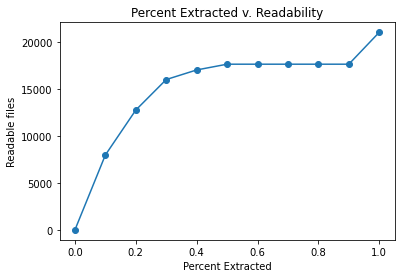

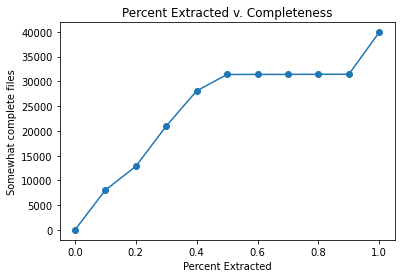

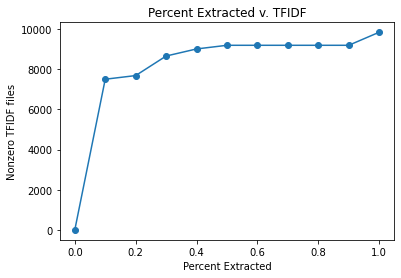

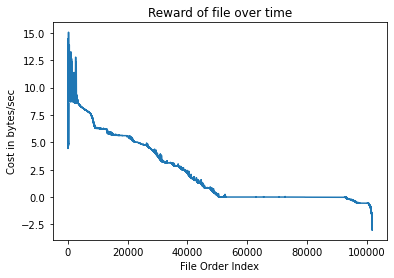

In [8]:
X = np.asarray(X)
Y_readability = np.asarray(Y_readability)
Y_completeness = np.asarray(Y_completeness)
Y_tfidf = np.asarray(Y_tfidf)

print(len(Y_readability))

plt.title("Percent Extracted v. Readability")
plt.xlabel("Percent Extracted")
plt.ylabel("Readable files")
plt.scatter(X, Y_readability)
plt.plot(X, Y_readability)
plt.show()

plt.title("Percent Extracted v. Completeness")
plt.xlabel("Percent Extracted")
plt.ylabel("Somewhat complete files")
plt.scatter(X, Y_completeness)
plt.plot(X, Y_completeness)
plt.show()

plt.title("Percent Extracted v. TFIDF")
plt.xlabel("Percent Extracted")
plt.ylabel("Nonzero TFIDF files")
plt.scatter(X, Y_tfidf)
plt.plot(X, Y_tfidf)
plt.show()

plt.title("Reward of file over time")
plt.xlabel("File Order Index")
plt.ylabel("Cost in bytes/sec")
plt.plot(range(0, len(cost_scores)), list(cost_scores.values()))
plt.show()

### Processing of average readability

In [9]:
print(len(average_readability))

11


In [10]:
average_readability_norm = np.array(average_readability)
average_readability_norm = average_readability_norm / np.max(average_readability_norm)
print(average_readability_norm)

[0.         0.9861336  1.         0.94263821 0.93855787 0.94001318
 0.94001318 0.94001318 0.94001318 0.94001318 0.95465024]


### Processing of average completeness

In [24]:
len(completeness_total[0.1])

cum_completeness = np.zeros(len(completeness_total))


cum_sum = 0
for idx, key in enumerate(completeness_total):
	cum_sum = np.sum(np.array(completeness_total[key]))
	cum_completeness[idx] = cum_sum

print(cum_completeness)

[     0.          44420.01891941  44640.8370644  111793.41207852
 113176.98036769 114135.95279284 114141.67406423 114143.04325738
 114148.9601278  114155.51269504 115889.94378068]


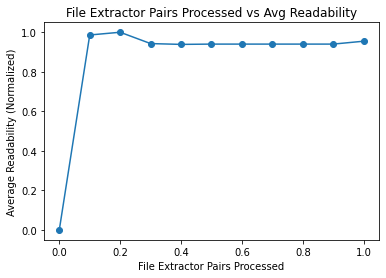

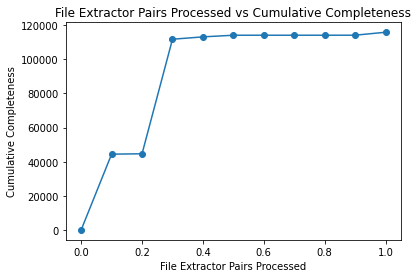

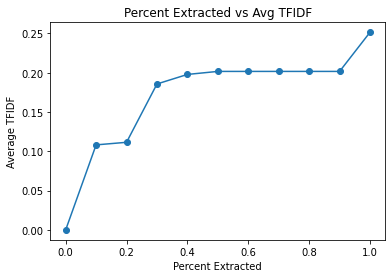

In [25]:
plt.scatter(X, average_readability_norm)
plt.plot(X, average_readability_norm)
plt.xlabel("File Extractor Pairs Processed")
plt.ylabel("Average Readability (Normalized)")
plt.title("File Extractor Pairs Processed vs Avg Readability")
plt.show()

plt.scatter(X, cum_completeness)
plt.plot(X, cum_completeness)
plt.xlabel("File Extractor Pairs Processed")
plt.ylabel("Cumulative Completeness")
plt.title("File Extractor Pairs Processed vs Cumulative Completeness")
plt.show()

plt.scatter(X, average_tfidf)
plt.plot(X, average_tfidf)
plt.xlabel("Percent Extracted")
plt.ylabel("Average TFIDF")
plt.title("Percent Extracted vs Avg TFIDF")
plt.show()

In [26]:
print(extractor_counts)

[{'keyword': 0, 'tabular': 0, 'json/xml': 0, 'netcdf': 0, 'image': 0}, {'keyword': 30, 'tabular': 7131, 'json/xml': 1469, 'netcdf': 1554, 'image': 0}, {'keyword': 30, 'tabular': 12261, 'json/xml': 1613, 'netcdf': 6465, 'image': 0}, {'keyword': 4912, 'tabular': 15151, 'json/xml': 2485, 'netcdf': 7321, 'image': 684}, {'keyword': 12132, 'tabular': 16228, 'json/xml': 3137, 'netcdf': 8282, 'image': 959}, {'keyword': 15125, 'tabular': 16847, 'json/xml': 3664, 'netcdf': 8683, 'image': 6603}, {'keyword': 15141, 'tabular': 16847, 'json/xml': 13833, 'netcdf': 8683, 'image': 6603}, {'keyword': 15144, 'tabular': 16847, 'json/xml': 20337, 'netcdf': 12360, 'image': 6603}, {'keyword': 15163, 'tabular': 16847, 'json/xml': 20367, 'netcdf': 20369, 'image': 8730}, {'keyword': 15179, 'tabular': 16847, 'json/xml': 20367, 'netcdf': 20369, 'image': 18898}, {'keyword': 20369, 'tabular': 20369, 'json/xml': 20369, 'netcdf': 20369, 'image': 20369}]


In [27]:
keyword_count = []
tabular_count = []
jsonxml_count = []
netcdf_count = []
image_count = []

file_count_list = []

for dictionary in extractor_counts:
	for key, value in dictionary.items():
		if key == "keyword":
			keyword_count.append(value)
		elif key == "tabular":
			tabular_count.append(value)
		elif key == "netcdf":
			netcdf_count.append(value)
		elif key == "json/xml":
			jsonxml_count.append(value)
		elif key == "image":
			image_count.append(value)
		else:
			print("Something went wrong")

for fc in file_counts:
	file_count_list.append(len(list(fc.keys())))
	

In [15]:
print(keyword_count)
print(tabular_count)
print(jsonxml_count)
print(netcdf_count)
print(image_count)
print(file_count_list)

[0, 30, 30, 4912, 12132, 15125, 15141, 15144, 15163, 15179, 20369]
[0, 7131, 12261, 15151, 16228, 16847, 16847, 16847, 16847, 16847, 20369]
[0, 1469, 1613, 2485, 3137, 3664, 13833, 20337, 20367, 20367, 20369]
[0, 1554, 6465, 7321, 8282, 8683, 8683, 12360, 20369, 20369, 20369]
[0, 0, 0, 684, 959, 6603, 6603, 6603, 8730, 18898, 20369]
[0, 10067, 15418, 20083, 20209, 20296, 20298, 20369, 20369, 20369, 20369]


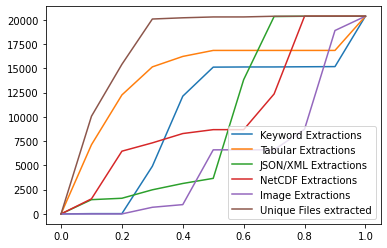

In [28]:
plt.plot(X, keyword_count, label="Keyword Extractions")
plt.plot(X, tabular_count, label="Tabular Extractions")
plt.plot(X, jsonxml_count, label="JSON/XML Extractions")
plt.plot(X, netcdf_count, label="NetCDF Extractions")
plt.plot(X, image_count, label="Image Extractions")
plt.plot(X, file_count_list, label="Unique Files extracted")
plt.legend()
plt.show()

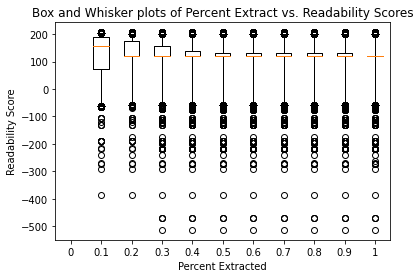

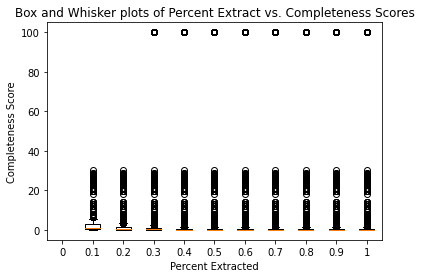

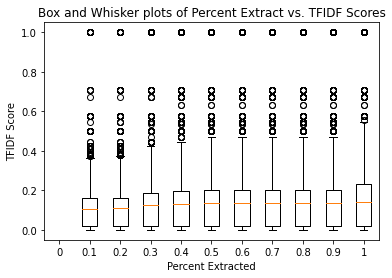

In [17]:
labels, data = [*zip(*readability_total.items())]  # 'transpose' items to parallel key, value lists
#for d in data:
	#print(d)

plt.boxplot(data, whis=[5, 95])
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("Box and Whisker plots of Percent Extract vs. Readability Scores")
plt.xlabel("Percent Extracted")
plt.ylabel("Readability Score")
plt.show()

labels, data = [*zip(*completeness_total.items())]  # 'transpose' items to parallel key, value lists
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Percent Extracted")
plt.ylabel("Completeness Score")
plt.title("Box and Whisker plots of Percent Extract vs. Completeness Scores")
plt.show()

labels, data = [*zip(*tfidf_total.items())]  # 'transpose' items to parallel key, value lists
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Percent Extracted")
plt.ylabel("TFIDF Score")
plt.title("Box and Whisker plots of Percent Extract vs. TFIDF Scores")
plt.show()



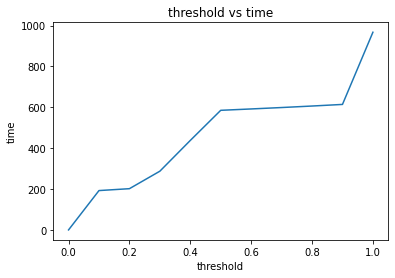

In [18]:
Threshold = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
Time = [0, 192.54913187026978, 201.7842311859131, 287.3370723724365, 437.8477611541748,  585.3103694915771, 591.996896982193, 598.9227044582367, 606.2875552177429, 614.1233706474304, 967.380571603775]
plt.plot(Threshold, Time)
plt.xlabel("threshold")
plt.ylabel("time")
plt.title("threshold vs time")
plt.show()